# Import Libraries

In [1]:
import sqlite3
import csv
import time
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display, HTML, Markdown

# Helper Functions

In [2]:
def parse_date(date_str):
    return datetime.strptime(date_str, '%m/%d/%Y').strftime('%Y-%m-%d')

def display_formatted_output(text, is_bold=False):
    if is_bold:
        display(Markdown(f"**{text}**"))
    else:
        display(Markdown(text))

# Database Loading Function

In [3]:
def load_csv_to_db(csv_file, db_name, table_name):
    conn = sqlite3.connect(db_name, timeout=10)
    conn.execute('PRAGMA journal_mode=WAL')
    conn.execute('PRAGMA synchronous=NORMAL')
    conn.execute('PRAGMA cache_size=-20000')
    
    # Drop existing table if any
    conn.execute(f'DROP TABLE IF EXISTS {table_name}')
    
    # Create table without PRIMARY KEY constraint
    conn.execute(f'''CREATE TABLE {table_name} (
                      PersonID INTEGER,
                      PersonName TEXT,
                      SchoolID TEXT,
                      SchoolName TEXT,
                      SchoolCampus TEXT,
                      DepartmentName TEXT,
                      DepartmentID TEXT,
                      BirthDate TEXT,
                      StillWorking TEXT,
                      JobID TEXT,
                      JobTitle TEXT,
                      Earnings REAL,
                      EarningsYear INTEGER
                  )''')
    
    insert_query = f'INSERT INTO {table_name} VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)'
    
    try:
        with open(csv_file, 'r') as file:
            reader = csv.reader(file)
            next(reader)  # Skip header
            
            rows = []
            for row in reader:
                try:
                    # Convert BirthDate
                    row[7] = parse_date(row[7])
                    # Convert numeric fields
                    row[0] = int(row[0])  # PersonID
                    row[11] = float(row[11])  # Earnings
                    row[12] = int(row[12])  # EarningsYear
                    rows.append(row)
                    
                    if len(rows) >= 5000:  # Reduced batch size
                        conn.executemany(insert_query, rows)
                        conn.commit()  # Commit each batch
                        rows = []
                except (ValueError, IndexError) as e:
                    print(f"Skipping invalid row: {row}")
                    continue
            
            # Insert remaining rows
            if rows:
                conn.executemany(insert_query, rows)
                conn.commit()
        
        # Create indexes after data insertion
        display_formatted_output("Creating indexes...", True)
        conn.execute(f'CREATE INDEX idx_{table_name}_personid ON {table_name} (PersonID)')
        conn.execute(f'CREATE INDEX idx_{table_name}_birthdate ON {table_name} (BirthDate)')
        conn.execute(f'CREATE INDEX idx_{table_name}_earnings ON {table_name} (Earnings)')
        conn.execute(f'CREATE INDEX idx_{table_name}_stillworking ON {table_name} (StillWorking)')
        conn.commit()
        
    except Exception as e:
        print(f"Error processing {csv_file}: {str(e)}")
        conn.rollback()
    finally:
        conn.close()
        
# Load data
csv_files = ['./csv_files/salary_tracker_1MB.csv', 
             './csv_files/salary_tracker_10MB.csv', 
             './csv_files/salary_tracker_100MB.csv']
table_names = ['salary_data_1MB', 'salary_data_10MB', 'salary_data_100MB']
db_name = 'salary_data.db'

for csv_file, table_name in zip(csv_files, table_names):
    display_formatted_output(f"Loading {csv_file} into {table_name}...")
    load_csv_to_db(csv_file, db_name, table_name)
    display_formatted_output("Loading complete!", True)

Loading ./csv_files/salary_tracker_1MB.csv into salary_data_1MB...

**Creating indexes...**

**Loading complete!**

Loading ./csv_files/salary_tracker_10MB.csv into salary_data_10MB...

**Creating indexes...**

**Loading complete!**

Loading ./csv_files/salary_tracker_100MB.csv into salary_data_100MB...

**Creating indexes...**

**Loading complete!**

# Define Queries

In [9]:
queries = {
    "1": """
        SELECT PersonName
        FROM {table_name} AS s1
        WHERE BirthDate < '1975-01-01' 
        AND Earnings > 130000
        AND EarningsYear = (
            SELECT MAX(EarningsYear) 
            FROM {table_name} AS s2 
            WHERE s1.PersonID = s2.PersonID
        ) ORDER BY PersonName ASC;
    """,
    "2": """
        SELECT DISTINCT PersonName, SchoolName
        FROM {table_name}
        WHERE Earnings > 400000 
        AND StillWorking = 'no';
    """,
    "3": """
        SELECT PersonName 
        FROM {table_name} 
        WHERE SchoolName LIKE '%University of Texas%' 
        AND JobTitle = 'Lecturer' 
        AND StillWorking = 'no';
    """,
    "4": """
        SELECT SchoolName, SchoolCampus, COUNT(*) as ActiveFacultyCount
        FROM {table_name}
        WHERE StillWorking = 'yes'
        GROUP BY SchoolName, SchoolCampus
        ORDER BY ActiveFacultyCount DESC
        LIMIT 1;
    """,
    "5": """
        SELECT PersonName, JobTitle, DepartmentName, SchoolName, Earnings
        FROM {table_name}
        WHERE PersonName LIKE '%Vinay Shetye%'
        AND EarningsYear = (
            SELECT MAX(EarningsYear)
            FROM {table_name}
            WHERE PersonName LIKE '%Vinay Shetye%'
        );
    """,
    "6": """
        SELECT DepartmentName, AVG(Earnings) as AvgEarnings
        FROM {table_name}
        GROUP BY DepartmentName
        ORDER BY AvgEarnings DESC
        LIMIT 1;
    """
}

# Performance Measurement Function

In [10]:
def measure_query_performance(db_name, table_name, query_template, query_num):
    conn = sqlite3.connect(db_name)
    conn.execute('PRAGMA cache_size=-20000')
    conn.execute('PRAGMA mmap_size=30000000000')
    
    query = query_template.format(table_name=table_name)
    
    # Display query details
    display_formatted_output(f"Query {query_num}", True)
    display_formatted_output(f"Table: {table_name}", True)
    display_formatted_output("SQL Query:")
    display_formatted_output(f"```sql\n{query}\n```")
    
    # Execute and measure
    start_time = time.time()
    results = pd.read_sql_query(query, conn)
    elapsed_time = time.time() - start_time
    
    display_formatted_output(f"Execution Time: {elapsed_time:.4f} seconds", True)
    display_formatted_output("\nResults:")
    display(results)
    
    # Plot individual query timing
    plt.figure(figsize=(8, 4))
    plt.bar(['Execution Time'], [elapsed_time])
    plt.title(f'Query {query_num} - {table_name}')
    plt.ylabel('Time (seconds)')
    plt.show()
    
    conn.close()
    return elapsed_time

# Execute Queries and Track Performance


==================================================

**Executing Query 1 across all database sizes**

==================================================


**Query 1**

**Table: salary_data_1MB**

SQL Query:

```sql

        SELECT PersonName
        FROM salary_data_1MB AS s1
        WHERE BirthDate < '1975-01-01' 
        AND Earnings > 130000
        AND EarningsYear = (
            SELECT MAX(EarningsYear) 
            FROM salary_data_1MB AS s2 
            WHERE s1.PersonID = s2.PersonID
        ) ORDER BY PersonName ASC;
    
```

**Execution Time: 0.0126 seconds**


Results:

,PersonName
0,Aaron Hernandez III
1,Aaron Hicks
2,Aaron Levy
3,Aaron Walsh
4,Aaron Weaver
...,...
1183,Zachary Smith
1184,Zachary Smith
1185,Zachary Stout
1186,Zachary Stout


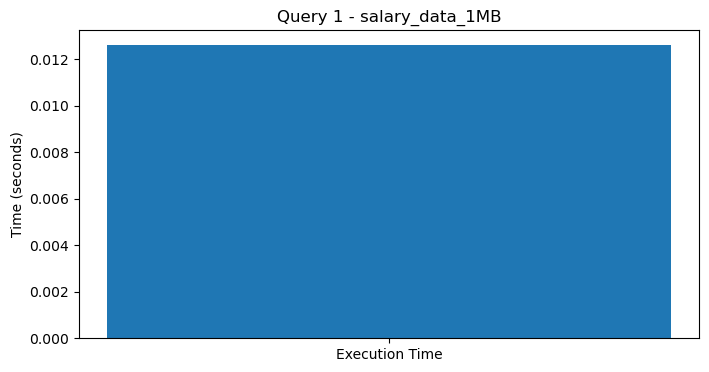

**Query 1**

**Table: salary_data_10MB**

SQL Query:

```sql

        SELECT PersonName
        FROM salary_data_10MB AS s1
        WHERE BirthDate < '1975-01-01' 
        AND Earnings > 130000
        AND EarningsYear = (
            SELECT MAX(EarningsYear) 
            FROM salary_data_10MB AS s2 
            WHERE s1.PersonID = s2.PersonID
        ) ORDER BY PersonName ASC;
    
```

**Execution Time: 0.1342 seconds**


Results:

,PersonName
0,- ARBAAZ
1,Aaron Bishop
2,Aaron Bishop
3,Aaron Castillo
4,Aaron Copeland
...,...
6303,Zachary Smith
6304,Zachary Williamson
6305,Zachary Williamson
6306,Zachary Young


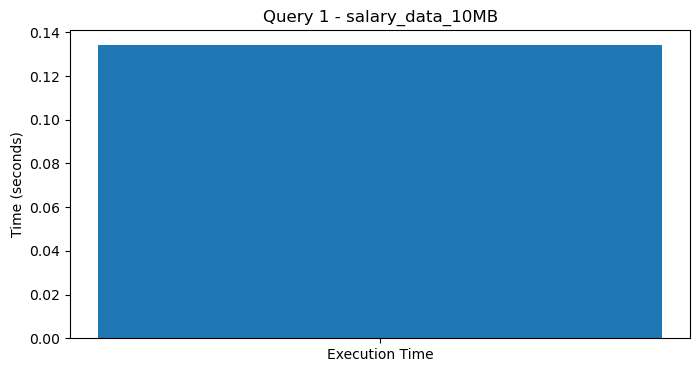

**Query 1**

**Table: salary_data_100MB**

SQL Query:

```sql

        SELECT PersonName
        FROM salary_data_100MB AS s1
        WHERE BirthDate < '1975-01-01' 
        AND Earnings > 130000
        AND EarningsYear = (
            SELECT MAX(EarningsYear) 
            FROM salary_data_100MB AS s2 
            WHERE s1.PersonID = s2.PersonID
        ) ORDER BY PersonName ASC;
    
```

**Execution Time: 1.5334 seconds**


Results:

,PersonName
0,- ARBAAZ
1,Aaron Ali
2,Aaron Boyer
3,Aaron Boyer
4,Aaron Boyer
...,...
62656,Zoe Wise
62657,Zoe Wise
62658,Zoe Wise
62659,Zoe Wise


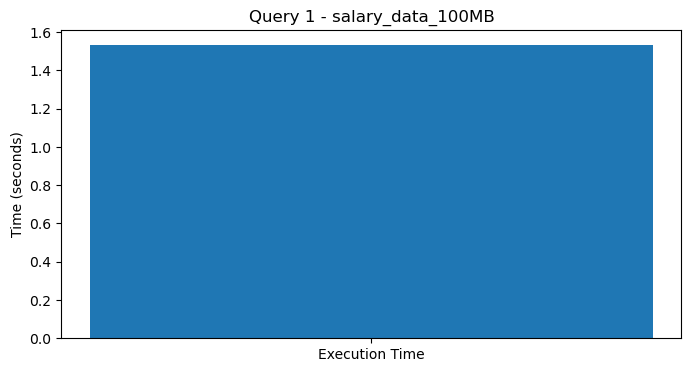


==================================================

**Executing Query 2 across all database sizes**

==================================================


**Query 2**

**Table: salary_data_1MB**

SQL Query:

```sql

        SELECT DISTINCT PersonName, SchoolName
        FROM salary_data_1MB
        WHERE Earnings > 400000 
        AND StillWorking = 'no';
    
```

**Execution Time: 0.0000 seconds**


Results:

,PersonName,SchoolName
0,Amber Solomon,University of Texas
1,Valerie Harvey,University of Massachusetts
2,Robert Moran,University of Florida
3,Amber Hartman,University of Massachusetts
4,Siddharth Munagala,University of Massachusetts
...,...,...
769,Joshua Davis,University of Texas
770,Douglas Woods,University of California
771,Sarah Harris,University of Massachusetts
772,Cynthia Boyer,University of Massachusetts


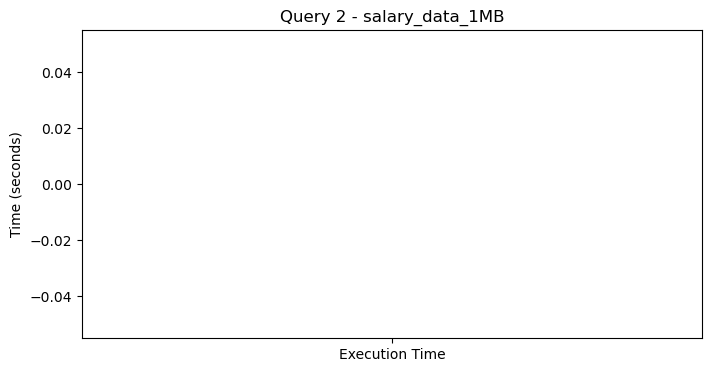

**Query 2**

**Table: salary_data_10MB**

SQL Query:

```sql

        SELECT DISTINCT PersonName, SchoolName
        FROM salary_data_10MB
        WHERE Earnings > 400000 
        AND StillWorking = 'no';
    
```

**Execution Time: 0.0381 seconds**


Results:

,PersonName,SchoolName
0,Charles Poole,University of Illinois
1,Vincent Walsh,University of Texas
2,David Lang,University of Illinois
3,Brianna Thompson,University of Massachusetts
4,Keith Robertson,University of Florida
...,...,...
5740,Rachel Weiss,University of Florida
5741,Brian Torres,University of Florida
5742,Christopher Hernandez,University of Florida
5743,Danielle Adams,University of Florida


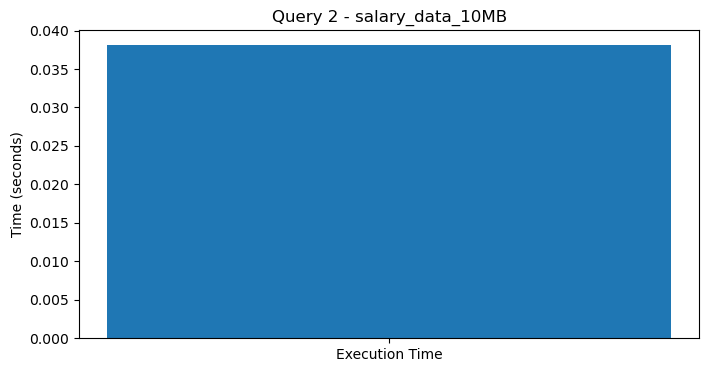

**Query 2**

**Table: salary_data_100MB**

SQL Query:

```sql

        SELECT DISTINCT PersonName, SchoolName
        FROM salary_data_100MB
        WHERE Earnings > 400000 
        AND StillWorking = 'no';
    
```

**Execution Time: 0.3501 seconds**


Results:

,PersonName,SchoolName
0,Christopher Barajas,University of California
1,Theodore Stewart,University of Texas
2,Jennifer Patrick MD,University of California
3,Brandon Williams,University of California
4,Rachael Mitchell,University of Massachusetts
...,...,...
34523,Lisa Luna,University of Florida
34524,Christian Dodson,University of Florida
34525,Joshua Goodman,University of Illinois
34526,Veronica Barrera,University of Illinois


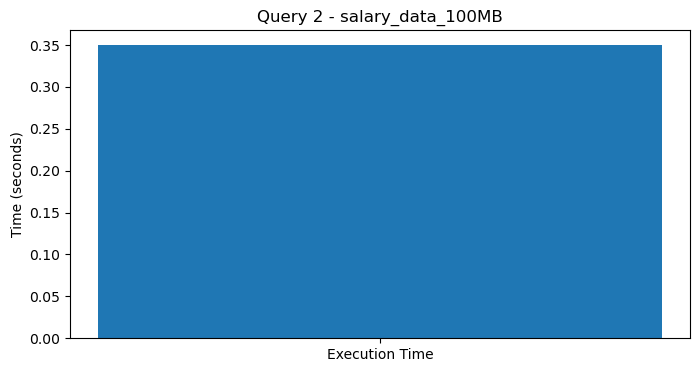


==================================================

**Executing Query 3 across all database sizes**

==================================================


**Query 3**

**Table: salary_data_1MB**

SQL Query:

```sql

        SELECT PersonName 
        FROM salary_data_1MB 
        WHERE SchoolName LIKE '%University of Texas%' 
        AND JobTitle = 'Lecturer' 
        AND StillWorking = 'no';
    
```

**Execution Time: 0.0000 seconds**


Results:

,PersonName
0,Jackson Becker
1,Veronica Blackburn
2,Veronica Blackburn
3,Kayla Stevenson
4,Scott Castillo
...,...
181,Kevin Dean
182,Louis Leblanc
183,Scott Mcclure
184,Scott Mcclure


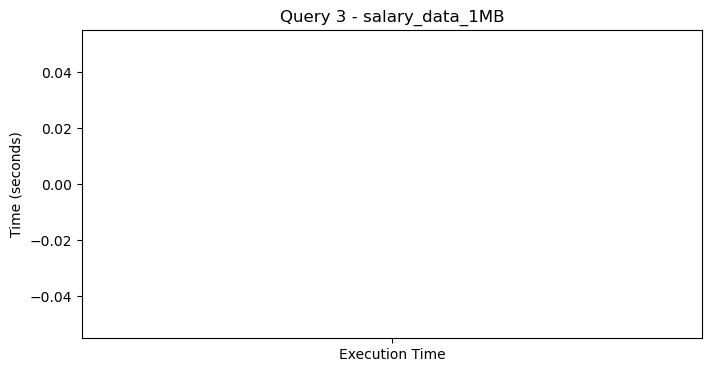

**Query 3**

**Table: salary_data_10MB**

SQL Query:

```sql

        SELECT PersonName 
        FROM salary_data_10MB 
        WHERE SchoolName LIKE '%University of Texas%' 
        AND JobTitle = 'Lecturer' 
        AND StillWorking = 'no';
    
```

**Execution Time: 0.0333 seconds**


Results:

,PersonName
0,Devin Cardenas
1,Kevin Wood
2,Zachary Moreno
3,Zachary Moreno
4,Zachary Moreno
...,...
1949,Monica Bowers
1950,Monica Bowers
1951,Erik Gutierrez
1952,Nicholas Cook


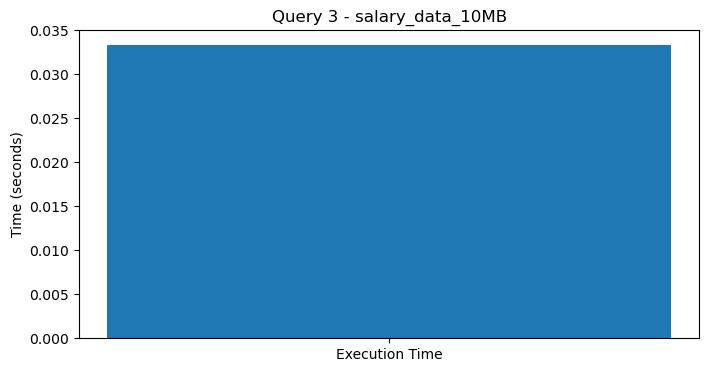

**Query 3**

**Table: salary_data_100MB**

SQL Query:

```sql

        SELECT PersonName 
        FROM salary_data_100MB 
        WHERE SchoolName LIKE '%University of Texas%' 
        AND JobTitle = 'Lecturer' 
        AND StillWorking = 'no';
    
```

**Execution Time: 0.3005 seconds**


Results:

,PersonName
0,Theodore Stewart
1,Theodore Stewart
2,Karen Potts
3,Karen Potts
4,John Rodriguez
...,...
19075,John Stevens
19076,Peter Vargas DVM
19077,Christopher Hogan
19078,Christopher Hogan


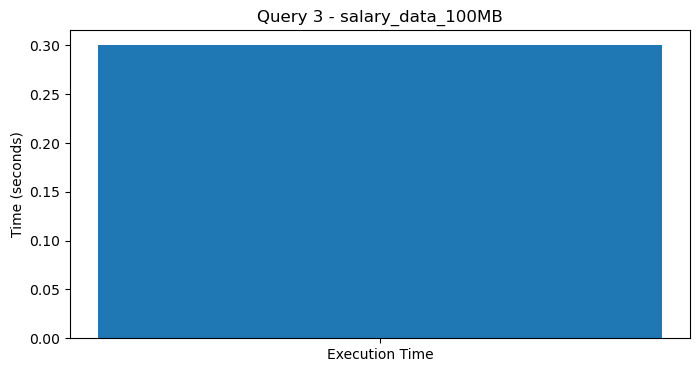


==================================================

**Executing Query 4 across all database sizes**

==================================================


**Query 4**

**Table: salary_data_1MB**

SQL Query:

```sql

        SELECT SchoolName, SchoolCampus, COUNT(*) as ActiveFacultyCount
        FROM salary_data_1MB
        WHERE StillWorking = 'yes'
        GROUP BY SchoolName, SchoolCampus
        ORDER BY ActiveFacultyCount DESC
        LIMIT 1;
    
```

**Execution Time: 0.0166 seconds**


Results:

,SchoolName,SchoolCampus,ActiveFacultyCount
0,University of Illinois,Springfield,69


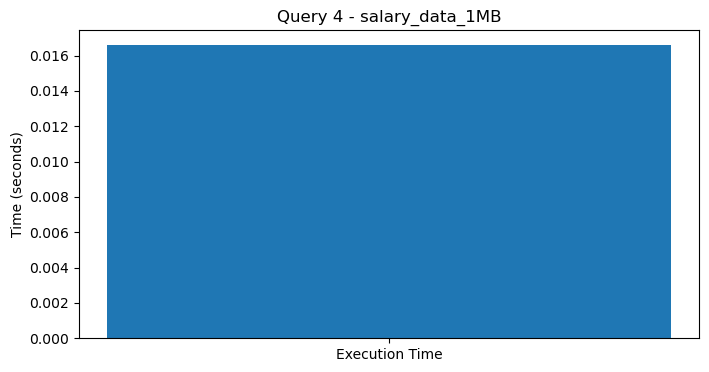

**Query 4**

**Table: salary_data_10MB**

SQL Query:

```sql

        SELECT SchoolName, SchoolCampus, COUNT(*) as ActiveFacultyCount
        FROM salary_data_10MB
        WHERE StillWorking = 'yes'
        GROUP BY SchoolName, SchoolCampus
        ORDER BY ActiveFacultyCount DESC
        LIMIT 1;
    
```

**Execution Time: 0.0000 seconds**


Results:

,SchoolName,SchoolCampus,ActiveFacultyCount
0,University of Massachusetts,Dartmouth,273


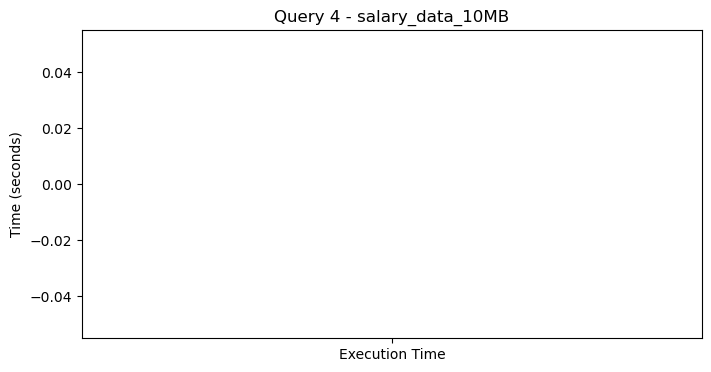

**Query 4**

**Table: salary_data_100MB**

SQL Query:

```sql

        SELECT SchoolName, SchoolCampus, COUNT(*) as ActiveFacultyCount
        FROM salary_data_100MB
        WHERE StillWorking = 'yes'
        GROUP BY SchoolName, SchoolCampus
        ORDER BY ActiveFacultyCount DESC
        LIMIT 1;
    
```

**Execution Time: 0.0885 seconds**


Results:

,SchoolName,SchoolCampus,ActiveFacultyCount
0,University of Massachusetts,Dartmouth,2874


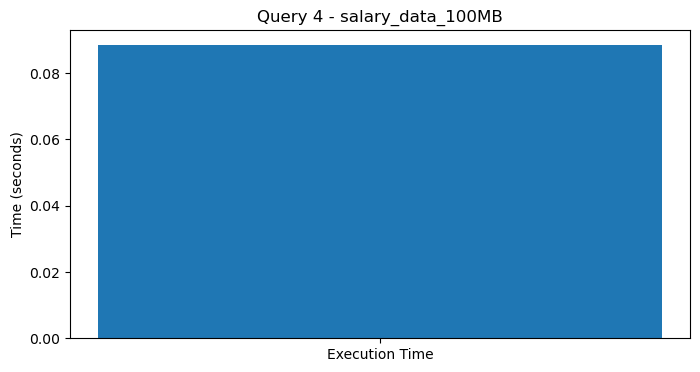


==================================================

**Executing Query 5 across all database sizes**

==================================================


**Query 5**

**Table: salary_data_1MB**

SQL Query:

```sql

        SELECT PersonName, JobTitle, DepartmentName, SchoolName, Earnings
        FROM salary_data_1MB
        WHERE PersonName LIKE '%Vinay Shetye%'
        AND EarningsYear = (
            SELECT MAX(EarningsYear)
            FROM salary_data_1MB
            WHERE PersonName LIKE '%Vinay Shetye%'
        );
    
```

**Execution Time: 0.0151 seconds**


Results:

,PersonName,JobTitle,DepartmentName,SchoolName,Earnings
0,Vinay Shetye,Engineer,Computer Science,University of Massachusetts,275731.0


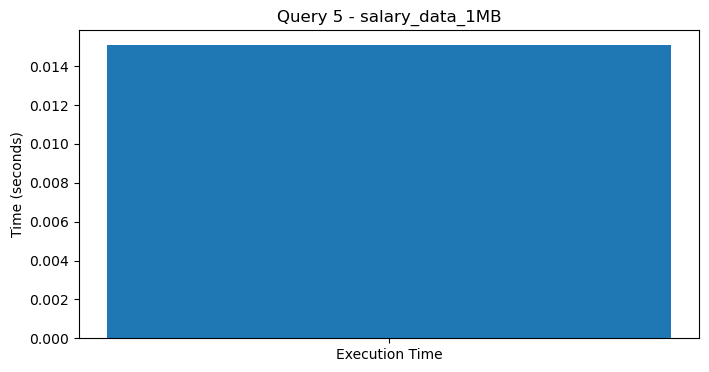

**Query 5**

**Table: salary_data_10MB**

SQL Query:

```sql

        SELECT PersonName, JobTitle, DepartmentName, SchoolName, Earnings
        FROM salary_data_10MB
        WHERE PersonName LIKE '%Vinay Shetye%'
        AND EarningsYear = (
            SELECT MAX(EarningsYear)
            FROM salary_data_10MB
            WHERE PersonName LIKE '%Vinay Shetye%'
        );
    
```

**Execution Time: 0.0343 seconds**


Results:

,PersonName,JobTitle,DepartmentName,SchoolName,Earnings
0,Vinay Shetye,Administrator,Chemistry,University of Massachusetts,165496.0


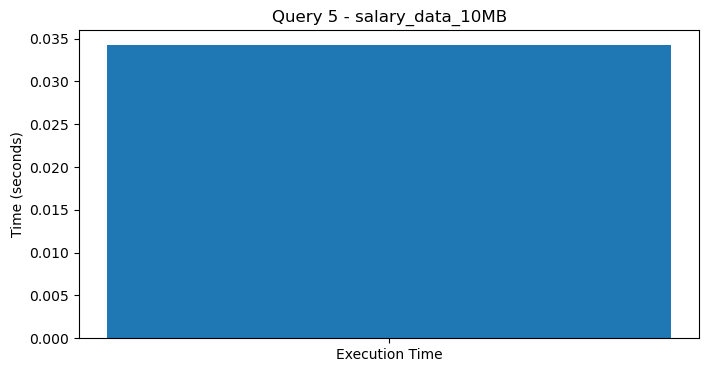

**Query 5**

**Table: salary_data_100MB**

SQL Query:

```sql

        SELECT PersonName, JobTitle, DepartmentName, SchoolName, Earnings
        FROM salary_data_100MB
        WHERE PersonName LIKE '%Vinay Shetye%'
        AND EarningsYear = (
            SELECT MAX(EarningsYear)
            FROM salary_data_100MB
            WHERE PersonName LIKE '%Vinay Shetye%'
        );
    
```

**Execution Time: 0.2492 seconds**


Results:

,PersonName,JobTitle,DepartmentName,SchoolName,Earnings
0,Vinay Shetye,Scientist,Computer Engineering,University of Massachusetts,330427.0


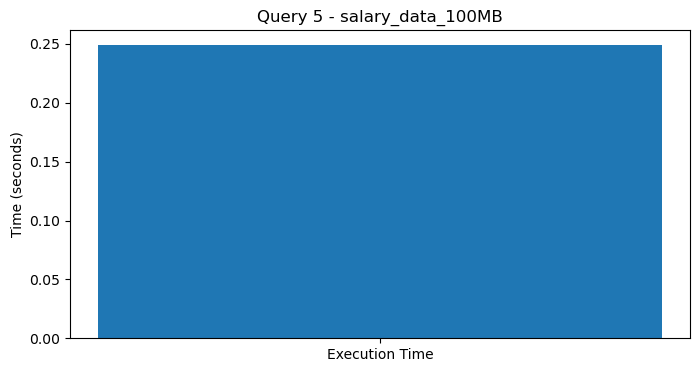


==================================================

**Executing Query 6 across all database sizes**

==================================================


**Query 6**

**Table: salary_data_1MB**

SQL Query:

```sql

        SELECT DepartmentName, AVG(Earnings) as AvgEarnings
        FROM salary_data_1MB
        GROUP BY DepartmentName
        ORDER BY AvgEarnings DESC
        LIMIT 1;
    
```

**Execution Time: 0.0165 seconds**


Results:

,DepartmentName,AvgEarnings
0,Computer Engineering,251579.588575


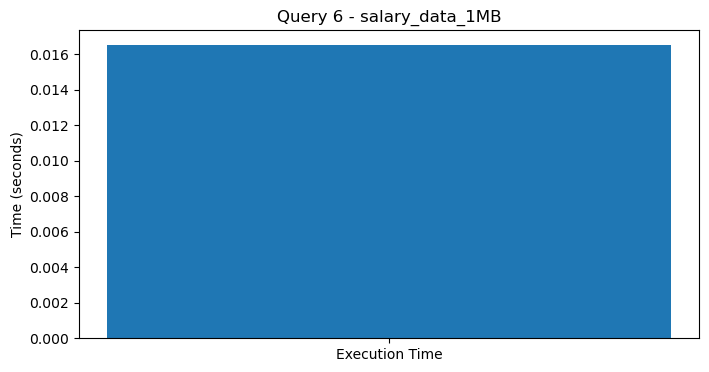

**Query 6**

**Table: salary_data_10MB**

SQL Query:

```sql

        SELECT DepartmentName, AVG(Earnings) as AvgEarnings
        FROM salary_data_10MB
        GROUP BY DepartmentName
        ORDER BY AvgEarnings DESC
        LIMIT 1;
    
```

**Execution Time: 0.0336 seconds**


Results:

,DepartmentName,AvgEarnings
0,Biology,240425.484315


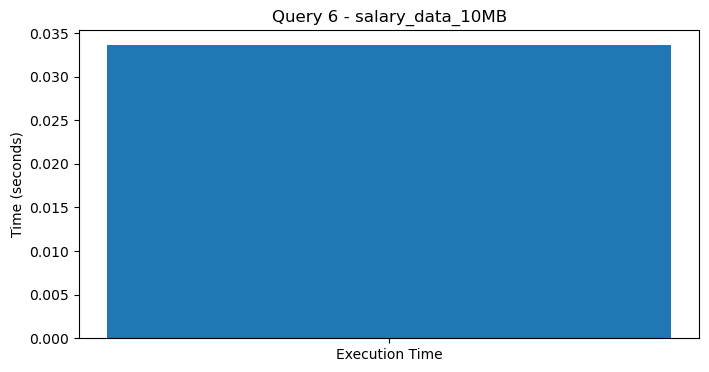

**Query 6**

**Table: salary_data_100MB**

SQL Query:

```sql

        SELECT DepartmentName, AVG(Earnings) as AvgEarnings
        FROM salary_data_100MB
        GROUP BY DepartmentName
        ORDER BY AvgEarnings DESC
        LIMIT 1;
    
```

**Execution Time: 0.5666 seconds**


Results:

,DepartmentName,AvgEarnings
0,Computer Engineering,236877.915586


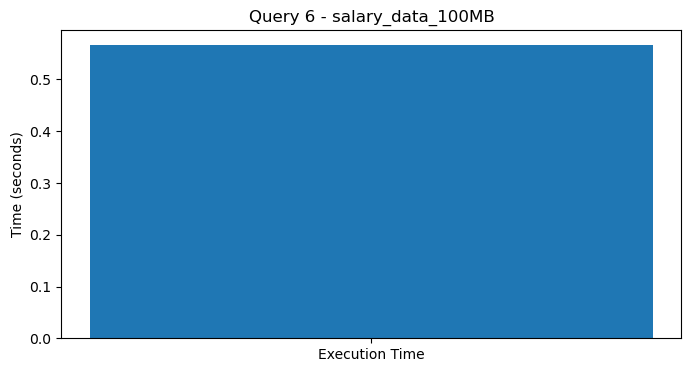

In [11]:
performance_results = {query_num: [] for query_num in queries.keys()}
file_sizes = ['1MB', '10MB', '100MB']

for query_num, query_template in queries.items():
    display_formatted_output(f"\n{'='*50}")
    display_formatted_output(f"Executing Query {query_num} across all database sizes", True)
    display_formatted_output(f"{'='*50}\n")
    
    query_times = []
    for table_name in table_names:
        time_taken = measure_query_performance(db_name, table_name, query_template, query_num)
        query_times.append(time_taken)
    performance_results[query_num] = query_times

# Final Performance Visualization

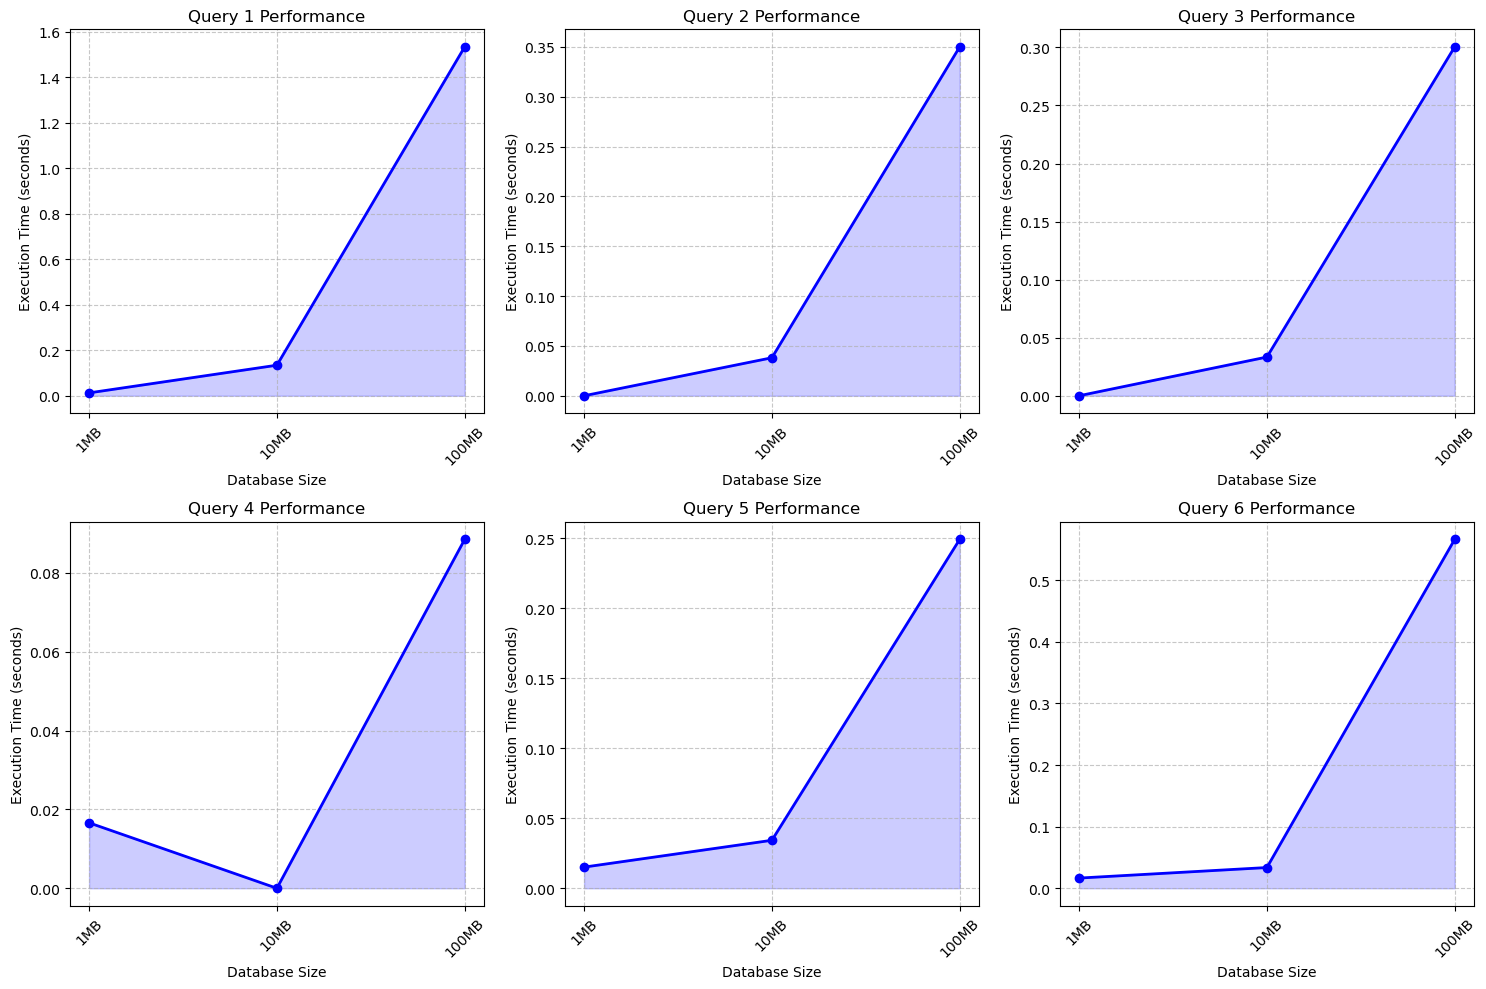

****Performance Summary (seconds):****

,Query 1,Query 2,Query 3,Query 4,Query 5,Query 6
1MB,0.012609,0.000000,0.000000,0.016599,0.015093,0.016532
10MB,0.134243,0.038127,0.033339,0.000000,0.034256,0.033636
100MB,1.533387,0.350063,0.300529,0.088508,0.249150,0.566559


In [14]:
plt.figure(figsize=(15, 10))
for i, (query_num, times) in enumerate(performance_results.items(), start=1):
    plt.subplot(2, 3, i)
    plt.plot(file_sizes, times, marker='o', linestyle='-', color='blue', linewidth=2)
    plt.fill_between(file_sizes, times, alpha=0.2, color='blue')
    plt.title(f'Query {query_num} Performance')
    plt.xlabel('Database Size')
    plt.ylabel('Execution Time (seconds)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Display summary table
summary_df = pd.DataFrame(performance_results, index=file_sizes)
summary_df.columns = [f'Query {i}' for i in range(1, 7)]
display_formatted_output("**Performance Summary (seconds):**", True)
display(summary_df)